In [17]:
import pandas as pd
import preprocessor as p
import re
import nltk
import string 
import seaborn as sns
from matplotlib import pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize  
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk import FreqDist
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from transformers import AutoTokenizer,TFBertModel,BertTokenizer
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn as nn

from transformers import BertTokenizer,BertModel, AdamW, get_linear_schedule_with_warmup

import numpy as np
import tensorflow as tf
from tensorflow.keras.losses import CategoricalCrossentropy,BinaryCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy,BinaryAccuracy
from wordcloud import WordCloud
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [21]:
train = pd.read_csv('train.csv', encoding='utf8')
test = pd.read_csv('test.csv', encoding='utf8')

In [22]:
train['text'].head()

0    Our Deeds are the Reason of this #earthquake M...
1               Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    Just got sent this photo from Ruby #Alaska as ...
Name: text, dtype: object

In [23]:
train.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

0    4342
1    3271
Name: target, dtype: int64


D:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='target'>

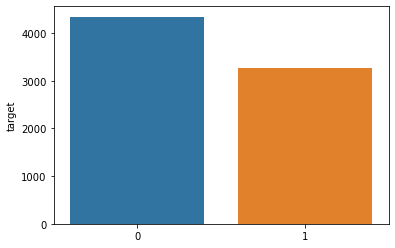

In [24]:
x=train['target'].value_counts()
print(x)
sns.barplot(x.index,x)

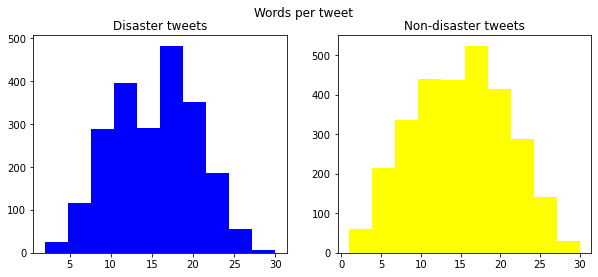

In [25]:
#REMOVEMOS DUPLICADOS DEL DS TRAIN

train = train.dropna()
train = train.drop_duplicates()
#--------------------------------------------------------------------------
#Pa
train['word_count'] = train['text'].apply(lambda x: len(str(x).split()))

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
train_words=train[train['target']==1]['word_count']
ax1.hist(train_words,color='blue')
ax1.set_title('Disaster tweets')
train_words=train[train['target']==0]['word_count']
ax2.hist(train_words,color='yellow')
ax2.set_title('Non-disaster tweets')
fig.suptitle('Words per tweet')
plt.show()

